# 分析师情绪专题

## 1.数据准备

In [1]:
import sys
import os
import numpy as np
import cudf  #CUDA计算
import pandas as pd

# 自行编写的包
sys.path.append('/home/ubuntu/notebook/Investor-Sentiment')
sys.path.append('/usr/local/stata17/utilities')

# 多核 groupby Apply
from pandarallel import pandarallel

# 数据库
from utils.sql import DB

from loader.findata_loader import DownLoader
from loader.findata_loader import Loader

# 统计工具
from statsmodels.regression.rolling import RollingOLS  #滚动回归
from statsmodels.regression.linear_model import OLS  #OLS回归

# Stata
from pystata import config  # noqa

config.init('mp')
# ------------------------------数据集路径----------------------------------#
DATASETS_PATH = '/data/DataSets/investor_sentiment/'

SystemError: initialization of _internal failed without raising an exception

In [ ]:
# 数据集:个股K线面板数据,个股基本面数据
# DownLoader().load_daily_data('shibor', 'FIN_DAILY_MACRO')

data_loader = Loader()

#### 指数盈利预测面板数据

In [3]:
data_loader.get_conidx_panel()

CON_YEAR        CON_OR        CON_NP  CON_EPS  \
trade_date ts_code                                                    
20131231   000002.SH      2013  2.150299e+09  1.996171e+08   0.6183   
           000010.SH      2013  1.616497e+09  1.803029e+08   0.7227   
           000015.SH      2013  9.223393e+08  1.402562e+08   0.7359   
           000016.SH      2013  1.095701e+09  1.190502e+08   0.7747   
           000067.SH      2013  1.304862e+08  7.875350e+06   0.5807   
...                        ...           ...           ...      ...   
20221028   399312.SZ      2022  3.583564e+09  3.023053e+08   1.1050   
           399313.SZ      2022  2.848629e+09  3.164494e+08   1.1574   
           399317.SZ      2022  7.321688e+09  5.934493e+08   0.7403   
           000985.SH      2022  7.224144e+09  5.840384e+08   0.7555   
           000688.SH      2022  6.009689e+07  7.351126e+06   1.0083   

                            CON_NA  CON_PB  CON_PS   CON_PE  CON_PEG  CON_ROE  \
trade_date ts_code                                                              
20131231   000002.SH  1.407965e+09  1.2913  0.8455   9.1078   0.5689    14.18   
           000010.SH  1.156060e+09  1.1894  0.8506   7.6264   0.5842    15.60   
           000015.SH  8.384264e+08  1.0141  0.9219   6.0624   0.5667    16.73   
           000016.SH  7.548906e+08  1.1679  0.8046   7.4054   0.5799    15.77   
           000067.SH  6.214941e+07  2.2588  1.0758  17.8255   0.9922    12.67   
...                            ...     ...     ...      ...      ...      ...   
20221028   399312.SZ  2.454648e+09  1.4467  0.9909  11.7465   0.7619    12.32   
           399313.SZ  2.754211e+09  0.9901  0.9572   8.6169   0.7773    11.49   
           399317.SZ  5.905421e+09  1.2950  1.0445  12.8868   0.7655    10.05   
           000985.SH  5.825681e+09  1.3191  1.0637  13.1574   0.7802    10.03   
           000688.SH  6.128843e+07  4.1037  4.1850  34.2135   0.9417    11.99   

                      CON_OR_YOY  CON_NP_YOY  CON_NPCGRATE_2Y  CON_PEI  
trade_date ts_code                                                      
20131231   000002.SH        9.89       18.25          16.0105  78.4365  
           000010.SH        8.21       13.78          13.0548  80.9011  
           000015.SH        5.53       11.24          10.6985  83.8420  
           000016.SH        7.24       13.37          12.7691  81.7573  
           000067.SH       12.46       16.76          17.9659  61.4964  
...                          ...         ...              ...      ...  
20221028   399312.SZ       15.04       15.51          15.4183  94.5570  
           399313.SZ       14.36       10.80          11.0863  94.4014  
           399317.SZ       10.82       15.55          16.8354  80.5216  
           000985.SH       10.96       15.11          16.8637  80.1858  
           000688.SH       43.95       46.41          36.3298  98.5569  

[43510 rows x 14 columns]

#### A股基本面面板数据

In [4]:
data_loader.get_ashare_panel()

open     high      low    close  pre_close  change  \
trade_date ts_code                                                            
20140102   000001.SZ   6.2109   6.3032   6.1751   6.2673     6.2776 -0.0103   
           000002.SZ   5.4033   5.4574   5.3559   5.4033     5.4303 -0.0270   
           000004.SZ  11.6400  11.8700  11.4500  11.8100    11.6500  0.1600   
           000005.SZ   2.5000   2.5200   2.4700   2.4900     2.5000 -0.0100   
           000006.SZ   3.8968   3.9047   3.8256   3.8494     3.8968 -0.0474   
...                       ...      ...      ...      ...        ...     ...   
20221130   872374.BJ   9.7300   9.8100   9.6500   9.6800     9.8500 -0.1700   
20221201   301290.SZ  49.8100  51.4900  47.9400  48.4800    53.1200 -4.6400   
           301311.SZ  20.4000  24.2800  20.1600  22.5600    20.0100  2.5500   
           870199.BJ  29.0000  30.8000  28.1800  30.8000    31.8000 -1.0000   
           872374.BJ   9.6300   9.7500   9.6300   9.7000     9.6800  0.0200   

                      share_return        vol       amount turnover_rate  ...  \
trade_date ts_code                                                        ...   
20140102   000001.SZ       -0.1641  489910.89  596223.7444        0.8786  ...   
           000002.SZ       -0.4972  485299.22  387391.0664        0.5016  ...   
           000004.SZ        1.3734    9714.74   11417.5556        1.1582  ...   
           000005.SZ       -0.4000   29997.74    7473.5909        0.3283  ...   
           000006.SZ       -1.2164   88230.28   43051.9277        0.6604  ...   
...                            ...        ...          ...           ...  ...   
20221130   872374.BJ       -1.7259    8135.76    7893.3140          <NA>  ...   
20221201   301290.SZ       -8.7349  108843.32  534442.0180       48.0937  ...   
           301311.SZ       12.7436  342502.29  750712.7690       60.1845  ...   
           870199.BJ       -3.1447   33555.95   97293.8040         28.93  ...   
           872374.BJ        0.2066    4895.79    4744.5780          <NA>  ...   

                           pb       ps   ps_ttm dv_ratio  dv_ttm  total_share  \
trade_date ts_code                                                              
20140102   000001.SZ   1.0563   2.5222   2.1079   0.8688  0.8688  819736.0665   
           000002.SZ   1.2891   0.8534   0.7309   2.2509  2.2509  1101372.497   
           000004.SZ  12.6589  10.1862   9.4261      0.0    <NA>    8397.6684   
           000005.SZ    3.486  22.8994  26.6946      0.0    <NA>   91433.3607   
           000006.SZ    1.749   2.1372   2.4689   1.9556  1.9556  134999.5046   
...                       ...      ...      ...      ...     ...          ...   
20221130   872374.BJ     <NA>     <NA>     <NA>     <NA>    <NA>         <NA>   
20221201   301290.SZ   2.2424  10.8767  10.6376     <NA>    <NA>   10017.3334   
           301311.SZ   3.1221   2.8278   2.8627     <NA>    <NA>      24000.0   
           870199.BJ   2.7135   4.5536   3.7651     <NA>    <NA>       4865.0   
           872374.BJ     <NA>     <NA>     <NA>     <NA>    <NA>         <NA>   

                      float_share   free_share     total_mv      circ_mv  
trade_date ts_code                                                        
20140102   000001.SZ  557590.1875  390867.8851  10025372.09  6819327.993  
           000002.SZ   967494.124  805584.6474   8799966.25  7730278.051  
           000004.SZ    8387.5459    6196.0792   99176.4638   99056.9171  
           000005.SZ   91374.3007   72950.2562  227669.0681  227522.0087  
           000006.SZ  133595.2936   65409.8872  657447.5874  650609.0798  
...                           ...          ...          ...          ...  
20221130   872374.BJ         <NA>         <NA>         <NA>         <NA>  
20221201   301290.SZ    2263.1536    2263.1536  485640.3232  109717.6865  
           301311.SZ    5690.8675    5690.8675     541440.0  128385.9708  
           870199.BJ       1159.9       1159.9     149842.0     

#### 指数基本面面板数据

In [5]:
data_loader.get_index_panel()

close        open        high         low  \
trade_date ts_code                                                     
20140102   000001.SH    2109.387    2112.126     2113.11    2101.016   
           000016.SH    1561.099    1570.049    1570.049    1553.476   
           000300.SH    2321.978    2323.433    2325.991    2310.653   
           000905.SH    3847.879    3823.316    3848.253    3813.806   
           399001.SZ    8114.388    8083.772    8124.558    8048.274   
...                          ...         ...         ...         ...   
20221207   000016.SH    2670.647   2678.6369   2705.2434   2661.2477   
           000300.SH   3958.4409   3956.6722   3999.5864   3944.1831   
           000905.SH   6204.0051   6198.0532   6243.9022   6183.3338   
           399001.SZ  11418.7632  11365.9813  11504.3936  11358.6814   
           399300.SZ        <NA>        <NA>        <NA>        <NA>   

                       pre_close    change shareindex_return          vol  \
trade_date ts_code                                                          
20140102   000001.SH    2115.978    -6.591           -0.3115   68485486.0   
           000016.SH    1574.781   -13.682           -0.8688   15725481.0   
           000300.SH    2330.026    -8.048           -0.3454   45194291.0   
           000905.SH    3829.096    18.783            0.4905   30800260.0   
           399001.SZ    8121.788      -7.4           -0.0911  76523675.97   
...                          ...       ...               ...          ...   
20221207   000016.SH   2684.8458  -14.1988           -0.5288   34532578.0   
           000300.SH   3968.1979    -9.757           -0.2459  143001356.0   
           000905.SH   6211.2515   -7.2464           -0.1167  137821246.0   
           399001.SZ  11398.8201   19.9431             0.175  445500812.0   
           399300.SZ        <NA>      <NA>              <NA>         <NA>   

                           amount      total_mv      float_mv   total_share  \
trade_date ts_code                                                            
20140102   000001.SH  61921354.65  1.816591e+13  1.355083e+13  3.233397e+12   
           000016.SH  14982557.38  8.764339e+12  7.067457e+12  1.536462e+12   
           000300.SH  49012211.12  1.724706e+13  1.263173e+13  2.880502e+12   
           000905.SH  31417807.02  3.684081e+12  2.879294e+12  4.173544e+11   
           399001.SZ  95994236.32  1.809932e+12  1.331610e+12  1.431701e+11   
...                           ...           ...           ...           ...   
20221207   000016.SH  64178141.48  1.798471e+13  1.500842e+13  1.586560e+12   
           000300.SH  255490829.0  4.800432e+13  3.634145e+13  4.012892e+12   
           000905.SH  155238837.7  1.237585e+13  1.067164e+13  1.360448e+12   
           399001.SZ  546530031.6  2.251881e+13  1.857781e+13  1.292449e+12   
           399300.SZ         <NA>  4.800432e+13  3.634145e+13  4.012892e+12   

                       float_share    free_share  turnover_rate  \
trade_date ts_code                                                
20140102   000001.SH  2.358476e+12  7.076779e+11           0.29   
           000016.SH  1.244444e+12  2.652202e+11           0.13   
           000300.SH  2.067522e+12  5.658356e+11           0.22   
           000905.SH  3.399529e+11  1.950857e+11           0.91   
           399001.SZ  1.126513e+11  7.292581e+10           0.64   
...                            ...           ...            ...   
20221207   000016.SH  1.232971e+12  3.381492e+11           0.28   
           000300.SH  2.885259e+12  1.092071e+12           0.50   
           000905.SH  1.181857e+12  6.334603e+11           1.17   
           399001.SZ  1.093008e+12  6.351503e+11           1.19   
           399300.SZ  2.885259e+12  1.092071e+12           0.50   

                      turnover_rate_f     pe  pe_ttm    pb  
trade_date ts_code                                          
20140102   000001.SH             0.96  10.71    9.64  1.34  
     

#### 时间序列数据

In [6]:
data_loader.get_time_series()

,img_neg,tex_neg,riskfree_return
trade_date,,,
20140102,0.0,0.0,0.015460
20140103,0.0,0.333333,0.015461
20140106,0.285714,0.142857,0.015481
20140107,0.0,0.333333,0.015489
20140108,0.333333,0.0,0.015506
...,...,...,...
20221212,<NA>,<NA>,0.006314
20221213,<NA>,<NA>,0.006342
20221214,<NA>,<NA>,0.006383


In [7]:
def merge_profit_con_basic():
    """
    合并指数基本面,一致预期,利润数据
    :return:
    """
    # ------------------------------------一致预期 - zyyx------------------------------------#
    df_idx_con = data_loader.get_conidx_panel().reset_index()
    df_idx_con['trade_year'] = df_idx_con['trade_date'] // 10000

    # ------------------------------------利润 - 人工录入 wugui-----------------------------------#
    df_profit = cudf.read_parquet(f'{DATASETS_PATH}IDX_PANEL_PROFIT.parquet').reset_index()
    df_profit = df_profit.groupby(by=['trade_year', 'ts_code'], as_index=False, ).first()
    df_profit['year_profit_l1'] = df_profit.groupby(by=['ts_code'], as_index=False, sort=True)['year_profit'].shift(1)
    df_profit.drop(columns='quarter', inplace=True)
    df_profit['year_profit_yoy'] = 100 * ((df_profit['year_profit'] / df_profit['year_profit_l1']) - 1)

    # ------------------------------------基本面 wugui------------------------------------#
    df_basic = cudf.read_parquet(f'{DATASETS_PATH}IDX_PANEL_BASIC_WUGUI.parquet').reset_index()
    df_basic['total_mv_l1'] = df_basic.groupby(by=['ts_code'], as_index=False, sort=True)['total_mv'].shift(1)
    df_basic['total_mv_chg'] = 100 * ((df_basic['total_mv'] / df_basic['total_mv_l1']) - 1)

    df_basic['close_l1'] = df_basic.groupby(by=['ts_code'], as_index=False, sort=True)['close'].shift(1)
    df_basic['close_chg'] = 100 * ((df_basic['close'] / df_basic['close_l1']) - 1)

    return (cudf.merge(
            cudf.merge(
                    cudf.merge(df_idx_con, df_profit, on=['trade_year', 'ts_code']), df_basic, on=['trade_date', 'ts_code']
            ),
            data_loader.get_time_series().reset_index(),
            on='trade_date')
    )


merge_profit_con_basic().set_index(['ts_code', 'trade_date', ]).sort_index()

CON_YEAR        CON_OR        CON_NP  CON_EPS  \
ts_code   trade_date                                                  
000010.SH 20140102        2014  1.229380e+09  2.013905e+08   0.8059   
          20140103        2014  1.229019e+09  2.014236e+08   0.8060   
          20140106        2014  1.228354e+09  2.012950e+08   0.8054   
          20140107        2014  1.223457e+09  2.010169e+08   0.8043   
          20140108        2014  1.224651e+09  2.010482e+08   0.8044   
...                        ...           ...           ...      ...   
399310.SZ 20221024        2022  1.521295e+09  1.557310e+08   1.3769   
          20221025        2022  1.522826e+09  1.557090e+08   1.3767   
          20221026        2022  1.522188e+09  1.556452e+08   1.3761   
          20221027        2022  1.520270e+09  1.548215e+08   1.3688   
          20221028        2022  1.525638e+09  1.543006e+08   1.3643   

                            CON_NA  CON_PB  CON_PS   CON_PE  CON_PEG  CON_ROE  \
ts_code   trade_date                                                            
000010.SH 20140102    1.356969e+09  1.0078  0.7662   6.7909   0.5332    14.84   
          20140103    1.357287e+09  0.9952  0.7572   6.7063   0.5262    14.84   
          20140106    1.357130e+09  0.9838  0.7486   6.6330   0.5219    14.83   
          20140107    1.356864e+09  0.9816  0.7487   6.6260   0.5246    14.81   
          20140108    1.356870e+09  0.9801  0.7474   6.6149   0.5234    14.82   
...                            ...     ...     ...      ...      ...      ...   
399310.SZ 20221024    1.157734e+09  1.4518  1.1049  10.7930   0.8422    13.45   
          20221025    1.157755e+09  1.4487  1.1014  10.7717   0.8464    13.45   
          20221026    1.157994e+09  1.4521  1.1047  10.8033   0.8501    13.44   
          20221027    1.154642e+09  1.4395  1.0933  10.7354   0.8510    13.41   
          20221028    1.151031e+09  1.4075  1.0619  10.4997   0.8521    13.41   

                      ...   mv_avg   float_mv   total_mv  total_mv_l1  \
ts_code   trade_date  ...                                               
000010.SH 20140102    ...   764.48   99561.25  136077.26    136823.66   
          20140103    ...   754.84   98313.66  134361.17    136077.26   
          20140106    ...   746.28   97112.08  132838.33    134361.17   
          20140107    ...   744.52   97002.79  132525.04    132838.33   
          20140108    ...   743.37   97025.44  132319.54    132525.04   
...                   ...      ...        ...        ...          ...   
399310.SZ 20221024    ...  3361.84  140653.69  168091.78    173613.12   
          20221025    ...  3354.74  140297.36  167736.80    168091.78   
          20221026    ...  3363.17  140721.14  168158.26    167736.80   
          20221027    ...  3324.34  138929.63  166216.95    168158.26   
          20221028    ...  3240.63  135486.47  162031.73    166216.95   

                      total_mv_chg  close_l1  close_chg   img_neg   tex_neg  \
ts_code   trade_date                                                          
000010.SH 20140102       -0.545520   5040.27  -0.599174       0.0       0.0   
          20140103       -1.261114   5010.07  -1.493991       0.0  0.333333   
          20140106       -1.133393   4935.22  -2.034357  0.285714  0.142857   
          20140107       -0.235843   4834.82  -0.002689       0.0  0.333333   
          20140108       -0.155065   4834.69   0.257307  0.333333       0.0   
...                            ...       ...        ...       ...       ...   
399310.SZ 20221024       -3.180255   5936.02  -3.541767      <NA>      <NA>   
          20221025       -0.211182   5725.78  -0.154564      <NA>      <NA>   
          20221026        0.251263   5716.93   0.586679      <NA>      <NA>   
          20221027       -1.154454   5750.47  -1.175208      <NA>      <NA>   
          20221028       -2.517926   5682.89  -2.940229      <NA>      <NA>   

                     riskfree_return  
ts_code   trade_date       

## 2.分析师情绪指标计算

In [8]:
def cal_analyst_sentiment_tdate():
    # 获取数据
    df_ana = merge_profit_con_basic()

    # 单位换算
    df_ana['CON_NP'] = df_ana['CON_NP'] / 10000
    df_ana['total_mv'] = df_ana['total_mv'] / 10000

    # 计算偏离
    df_ana['opt_profit_yoy'] = ((df_ana['CON_NP_YOY'] - df_ana['year_profit_yoy']) / df_ana['year_profit_yoy'].abs()) * 100
    df_ana['opt_pe'] = ((df_ana['CON_PE'] - df_ana['year_pe_ttm']) / df_ana['year_pe_ttm'].abs()) * 100
    df_ana['opt_profit'] = ((df_ana['CON_NP'] - df_ana['year_profit']) / df_ana['year_profit'].abs()) * 100

    # 计算组中日期
    df_ana['time'] = df_ana.groupby(by=['ts_code'])['trade_date'].rank()

    # 计算平方项
    df_ana['close_chg_s'] = df_ana['close_chg'] * df_ana['close_chg']

    # 转换数据
    return (df_ana.set_index(['trade_date', 'ts_code']).sort_index().reset_index().to_pandas()
            .astype(dtype={"trade_date": "str", "trade_year": "uint32"}))


df_analyst = cal_analyst_sentiment_tdate()
df_analyst.set_index(['trade_date', 'ts_code'])

CON_YEAR        CON_OR        CON_NP  CON_EPS  \
trade_date ts_code                                                    
20140102   000010.SH      2014  1.229380e+09  20139.051805   0.8059   
           000015.SH      2014  5.889377e+08  15328.983195   0.8057   
           000016.SH      2014  8.063073e+08  13294.314326   0.8620   
           000300.SH      2014  1.553438e+09  22802.196329   0.7898   
           000903.SH      2014  1.219844e+09  20305.917391   0.8299   
...                        ...           ...           ...      ...   
20221028   000906.SH      2022  5.610430e+09  51796.277367   0.9641   
           000985.SH      2022  7.224144e+09  58403.840993   0.7555   
           399005.SZ      2022  3.308684e+08   3156.638702   0.9635   
           399006.SZ      2022  1.580034e+08   1800.383211   1.3799   
           399310.SZ      2022  1.525638e+09  15430.058098   1.3643   

                            CON_NA  CON_PB  CON_PS   CON_PE  CON_PEG  CON_ROE  \
trade_date ts_code                                                              
20140102   000010.SH  1.356969e+09  1.0078  0.7662   6.7909   0.5332    14.84   
           000015.SH  9.912300e+08  0.8505  0.8438   5.4999   0.5358    15.46   
           000016.SH  8.877149e+08  0.9876  0.7290   6.5949   0.5269    14.98   
           000300.SH  1.569081e+09  1.0997  0.7828   7.5674   0.5488    14.53   
           000903.SH  1.353838e+09  0.9884  0.7627   6.5896   0.5254    15.00   
...                            ...     ...     ...      ...      ...      ...   
20221028   000906.SH  4.774941e+09  1.1471  0.9763  10.5749   0.7286    10.85   
           000985.SH  5.825681e+09  1.3191  1.0637  13.1574   0.7802    10.03   
           399005.SZ  2.227230e+08  2.8926  1.9471  20.4090   0.5528    14.17   
           399006.SZ  1.220097e+08  4.4799  3.4594  30.3598   0.7268    14.76   
           399310.SZ  1.151031e+09  1.4075  1.0619  10.4997   0.8521    13.41   

                      ...   close_l1  close_chg  img_neg  tex_neg  \
trade_date ts_code    ...                                           
20140102   000010.SH  ...  5040.2700  -0.599174      0.0      0.0   
           000015.SH  ...  1681.4600  -0.397274      0.0      0.0   
           000016.SH  ...  1574.7800  -0.868693      0.0      0.0   
           000300.SH  ...  2330.0300  -0.345489      0.0      0.0   
           000903.SH  ...  2155.2300  -0.593904      0.0      0.0   
...                   ...        ...        ...      ...      ...   
20221028   000906.SH  ...  4024.5400  -2.622412      NaN      NaN   
           000985.SH  ...  4640.7167  -2.964490      NaN      NaN   
           399005.SZ  ...  7293.5300  -3.140318      NaN      NaN   
           399006.SZ  ...  2337.2500  -3.711199      NaN      NaN   
           399310.SZ  ...  5682.8900  -2.940229      NaN      NaN   

                      riskfree_return  opt_profit_yoy     opt_pe  opt_profit  \
trade_date ts_code                                                             
20140102   000010.SH         0.015460      106.321095 -36.175752    6.534466   
           000015.SH         0.015460       19.072326 -30.115629    4.676568   
           000016.SH         0.015460      131.053412 -32.636364    6.312925   
           000300.SH         0.015460       76.005909 -36.833055    7.697893   
           000903.SH         0.015460       80.367172 -35.141732    6.049136   
...                               ...             ...        ...         ...   
20221028   000906.SH         0.004842      203.012356 -18.087529   40.330525   
           000985.SH         0.004842      241.903541 -22.694477   36.381384   
           399005.SZ         0.004842       83.540859 -23.129944   50.151677   
           399006.SZ         0.004842     8845.061854 -24.327517   52.148060   
           399310.SZ         0.004842      202.048409 -17.063981   35.863497   

                        time  close_chg_s  
trade_date ts_code                         
20140102   000010

## 3.媒体情绪对分析师情绪的影响

In [9]:
# @formatter:off

### 描述性统计

In [10]:
%%stata -d df_analyst -force
logout, save(Investor-Sentiment/outputs/Table_Sum) replace: tabstat *_neg total_mv pe_ttm_weight , ///
s(N sd mean p50 min max ) f(%12.4f) c(s)


. logout, save(Investor-Sentiment/outputs/Table_Sum) replace: tabstat *_neg tot
> al_mv pe_ttm_weight , ///
> s(N sd mean p50 min max ) f(%12.4f) c(s)

    Variable |            N           SD         Mean          p50          Min
-------------+-----------------------------------------------------------------
     img_neg |   22652.0000       0.1437       0.2015       0.2105       0.0000
     tex_neg |   22652.0000       0.1520       0.1957       0.1935       0.0000
    total_mv |   23565.0000      18.4808      22.6005      18.6206       0.8296
pe_ttm_wei~t |   23565.0000      15.3438      19.6109      13.2300       4.8400
-------------------------------------------------------------------------------

    Variable |          Max
-------------+-------------
     img_neg |       1.0000
     tex_neg |       1.0000
    total_mv |      97.4151
pe_ttm_wei~t |     138.8300
---------------------------

. 


分析师情绪描述性统计

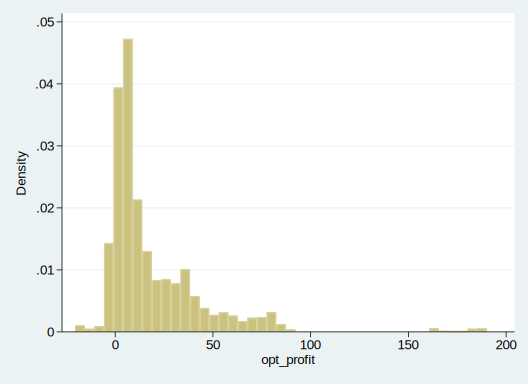

In [11]:
%%stata -d df_analyst -force -qui
est clear
encode ts_code,gen(id)
winsor2 opt_profit, cut(0.5 99.5) by(id) label
histogram opt_profit,  ylabel(, angle(0))

预期与实际盈利预测绘图

In [12]:
%%stata -d df_analyst -force -qui -nogr

//模型设定
encode ts_code,gen(id)
ge dt = date(trade_date, "YMD")
format dt %tdCCYYNNDD
xtset id dt

//组别
egen group = group(ts_code)
su group, meanonly

//循环绘图
forvalues i = 1/`r(max)' {
    twoway (tsline CON_NP, yaxis(1) lpattern(solid)) ///
    (tsline opt_profit, yaxis(2) lpattern(tight_dot)) ///
    if (group == `i' )&(time<=1900), ///
    ytitle(Profit ,axis(1)) ytitle("Bias (%)",axis(2))  ///
    xtitle("") legend(off) scheme(sj) xsize(10) ylabel(, nogrid) ///
    xlabel(, labgap(medium)) ///
    name(code`i',replace) title(".SH")
}

图片合成

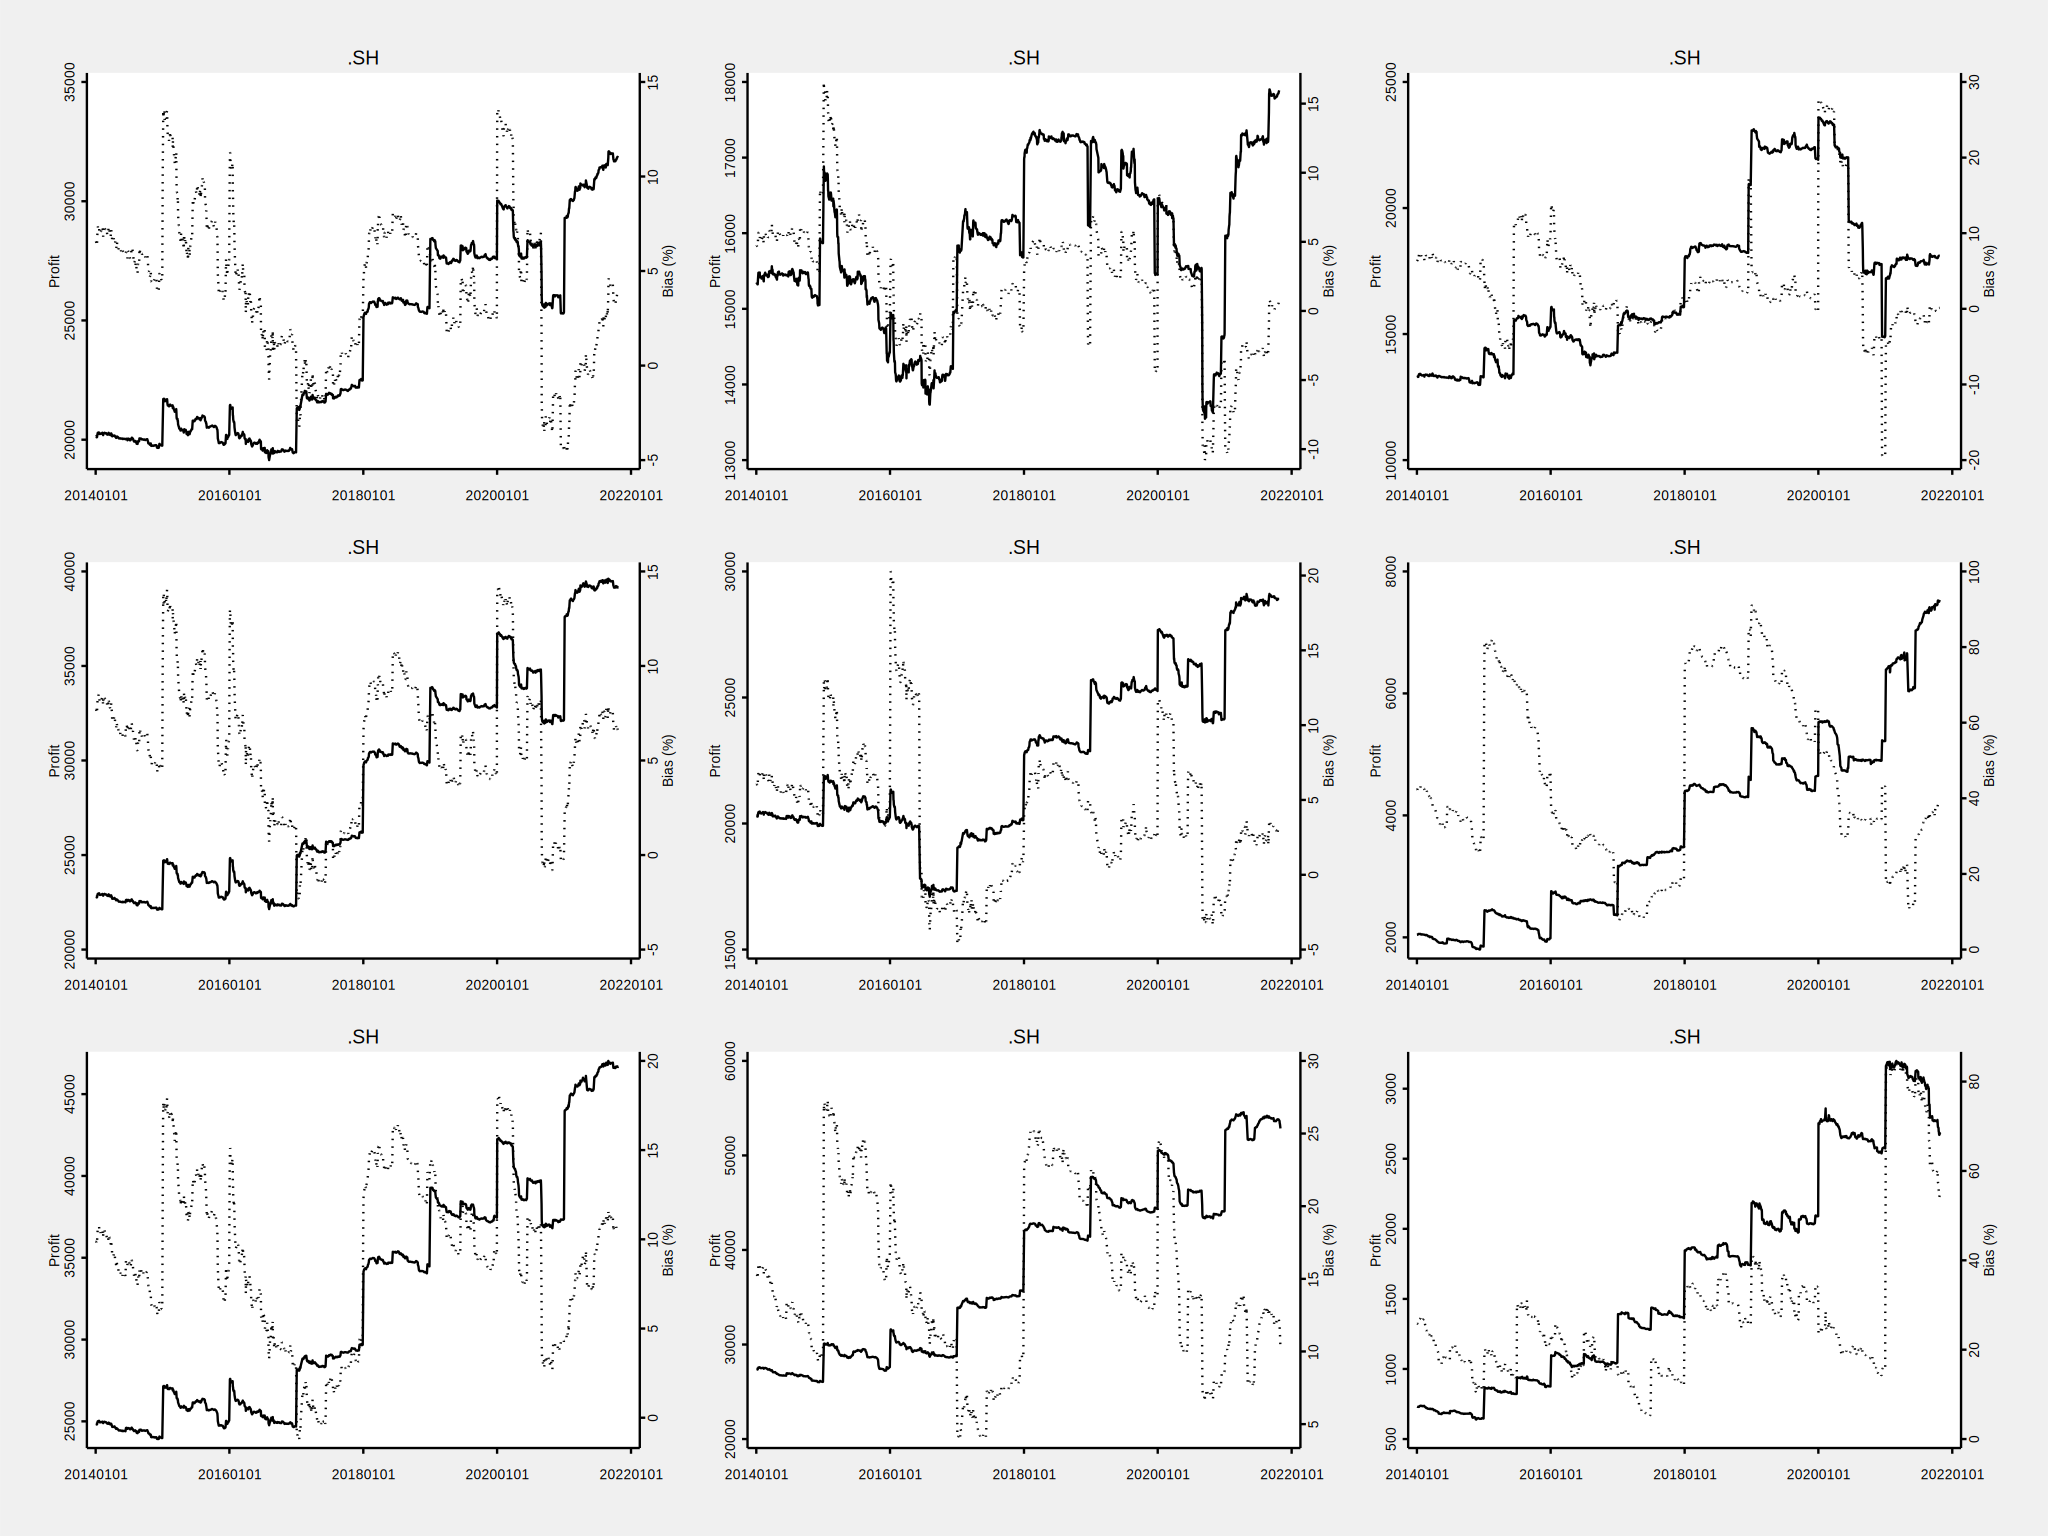

In [13]:
%%stata -gw 12in -gh 9in -qui
graph combine code1 code2 code3 code4 code5 code6 code7 code8 code9, name(c1,replace) scale(0.4) scheme(sj)
graph export Investor-Sentiment/outputs/imgs/opt_profit.svg ,replace

### 模型设定

"000010.SH","000015.SH","000016.SH","000300.SH","000903.SH","000905.SH","000906.SH","000985.SH" 399305.SZ 399306.SZ 399310.SZ

In [14]:
%%stata -d df_analyst -force -qui

//声明面板数据
encode ts_code,gen(id)
xtset id time

//缩尾
winsor2 opt_profit, cut(1 99) by(id) label replace

//变量对数处理
foreach var in opt_profit total_mv pe_ttm_weight profit_avg {
    ge ln`var'=ln(`var')
}

### 文本情绪基准回归

In [15]:
%%stata
//清除估计结果
est clear

//文本情绪回归
rename(tex_neg) (media_neg)
by id, sort : eststo:  qui reg  lnopt_profit L.media_neg L.lntotal_mv L.lnpe_ttm_weight L.lnprofit_avg   i.trade_year   ///
if inlist(ts_code ,"000010.SH","000015.SH","000016.SH","000300.SH","000903.SH","000905.SH","000906.SH","000985.SH"),r
rename(media_neg) (tex_neg)

//增加固定效应
estadd local Year "Yes" : *

//输出
esttab using Investor-Sentiment/outputs/media_to_analyst_text.rtf,r type ///
star(* 0.1 ** 0.05 *** 0.01) ///
keep(*_neg L.* ) ///
stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
nogaps compress b(%12.4f) ///
title("Table MediaSent to AnalystSent Text") ///
mtitle("000010.SH" "000015.SH" "000016.SH" "000300.SH" "000903.SH" "000905.SH" "000906.SH" "000985.SH")


. //清除估计结果
. est clear

. 
. //文本情绪回归
. rename(tex_neg) (media_neg)

. by id, sort : eststo:  qui reg  lnopt_profit L.media_neg L.lntotal_mv L.lnpe_
> ttm_weight L.lnprofit_avg   i.trade_year   ///
> if inlist(ts_code ,"000010.SH","000015.SH","000016.SH","000300.SH","000903.SH
> ","000905.SH","000906.SH","000985.SH"),r

-------------------------------------------------------------------------------
-> 000010.SH
(est1 stored)

-------------------------------------------------------------------------------
-> 000015.SH
(est2 stored)

-------------------------------------------------------------------------------
-> 000016.SH
(est3 stored)

-------------------------------------------------------------------------------
-> 000300.SH
(est4 stored)

-------------------------------------------------------------------------------
-> 000903.SH
(est5 stored)

-------------------------------------------------------------------------------
-> 000905.SH
(est6 stored)

-----------------------------

### 图像情绪基准回归

In [16]:
%%stata
//清除估计结果
est clear

//图像情绪回归
rename(img_neg) (media_neg)
by id, sort : eststo:  qui reg  lnopt_profit L.media_neg  L.lntotal_mv L.lnpe_ttm_weight L.lnprofit_avg   i.trade_year   ///
if inlist(ts_code ,"000010.SH","000015.SH","000016.SH","000300.SH","000903.SH","000905.SH","000906.SH","000985.SH"),r
rename(media_neg) (img_neg)

//增加固定效应
estadd local Year "Yes" : *

//输出
esttab using Investor-Sentiment/outputs/media_to_analyst_img.rtf,r type ///
star(* 0.1 ** 0.05 *** 0.01) ///
keep(*_neg L.* ) ///
stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
nogaps compress b(%12.4f) ///
title("Table MediaSent to AnalystSent Img") ///
mtitle("000010.SH" "000015.SH" "000016.SH" "000300.SH" "000903.SH" "000905.SH" "000906.SH" "000985.SH")


. //清除估计结果
. est clear

. 
. //图像情绪回归
. rename(img_neg) (media_neg)

. by id, sort : eststo:  qui reg  lnopt_profit L.media_neg  L.lntotal_mv L.lnpe
> _ttm_weight L.lnprofit_avg   i.trade_year   ///
> if inlist(ts_code ,"000010.SH","000015.SH","000016.SH","000300.SH","000903.SH
> ","000905.SH","000906.SH","000985.SH"),r

-------------------------------------------------------------------------------
-> 000010.SH
(est1 stored)

-------------------------------------------------------------------------------
-> 000015.SH
(est2 stored)

-------------------------------------------------------------------------------
-> 000016.SH
(est3 stored)

-------------------------------------------------------------------------------
-> 000300.SH
(est4 stored)

-------------------------------------------------------------------------------
-> 000903.SH
(est5 stored)

-------------------------------------------------------------------------------
-> 000905.SH
(est6 stored)

----------------------------

## 3.分析师情绪对股票市场的影响

In [17]:
%%stata
des


Contains data
 Observations:        23,565                  
    Variables:            59                  
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
trade_date      str9    %9s                   
ts_code         str9    %9s                   
CON_YEAR        long    %12.0g                
CON_OR          double  %10.0g                
CON_NP          double  %10.0g                
CON_EPS         double  %10.0g                
CON_NA          double  %10.0g                
CON_PB          double  %10.0g                
CON_PS          double  %10.0g                
CON_PE          double  %10.0g                
CON_PEG         double  %10.0g                
CON_ROE         double  %10.0g                
CON_OR_YOY      double  %10.0g                
CON_NP_YOY      do

In [18]:
%%stata
est clear

//缩尾
winsor2 close_chg, cut(1 99) by(id) label replace

//分组回归

reg close_chg c.L.img_neg##c.L.lnopt_profit L.close_chg L.close_chg_s  i.trade_year ,r


. est clear

. 
. //缩尾
. winsor2 close_chg, cut(1 99) by(id) label replace

. 
. //分组回归
. 
. reg close_chg c.L.img_neg##c.L.lnopt_profit L.close_chg L.close_chg_s  i.trad
> e_year ,r

Linear regression                               Number of obs     =     19,924
                                                F(13, 19910)      =      10.55
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0072
                                                Root MSE          =     1.4983

------------------------------------------------------------------------------
             |               Robust
   close_chg | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
     img_neg |
         L1. |   -.357827   .1317943    -2.72   0.007    -.6161549   -.0994991
             |
lnopt_profit |
         L1. |  -.0055